In [1]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
import os
import cv2
from keras.models import load_model
from sklearn.utils import shuffle
import seaborn as sns
from scipy.io import loadmat
import pandas as pd
import numpy as np
from random import shuffle

import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


# Data Preprocessing

In [2]:
def fer_data_preprocessing(model):
    fer_path = '../Data/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013/fer2013.csv'
    
    #Loading the data from file system
    data = pd.read_csv(fer_path)
    
    width, height = 48, 48
    image_size = (width, height)
    
    #Extracting and processing training data
    training_pixels = data[data['Usage'] == 'Training']['pixels'].tolist()
    X_train = []
    for pixel_sequence in training_pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        X_train.append(face.astype('float32'))
    X_train = np.asarray(X_train)
    if model == 1:
        X_train = np.expand_dims(X_train, -1)
    elif model == 2:
        X_train = X_train.reshape(X_train.shape[0], -1)
        
    y_train = pd.get_dummies(data[data['Usage'] == 'Training']['emotion']).values
    
    
    #Loading and processing Test data
    test_pixels = data[data['Usage'] == 'PublicTest']['pixels'].tolist()
    X_test = []
    for pixel_sequence in test_pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        X_test.append(face.astype('float32'))
    X_test = np.asarray(X_test)
    if model == 1:
        X_test = np.expand_dims(X_test, -1)
    elif model == 2:
        X_test = X_test.reshape(X_test.shape[0], -1)
    y_test = pd.get_dummies(data[data['Usage'] == 'PublicTest']['emotion']).values
    
    return X_train, y_train, X_test, y_test

# Keras Neural Network Model Implementation

In [3]:
class Keras_NN:
    def __init__(self,X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        
    def train_model(self):
        IMG_SIZE = 48
        model = Sequential()
        model.add(Conv2D(64, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(7, activation = 'softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(self.X_train, self.Y_train, batch_size=len(self.X_train)//20, epochs=20, verbose=1)
        
        return model
    
    def load_model(self):
        model = load_model('keras_on_fer')
        return model
    
    def save_model(self, model, name):
        model.save(name)

# WebCam Functions


In [4]:
def display_emotions(model, videoFaces, frame, bboxes):
    '''
    Fetches the emotions by using model prediction and adds 
    them to the output frame
    '''
    y_translation = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}
    outputFrame = frame.copy()
    predictions = model.predict(videoFaces)
    for i in range(len(bboxes)):
        emotion = y_translation[np.argmax(predictions[i])]
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(outputFrame, emotion, (bboxes[i][0] -1 ,bboxes[i][1] - 1), font, 1, (0,255,0), 2, cv2.LINE_AA)
        cv2.rectangle(outputFrame, (bboxes[i][0], bboxes[i][1]), (bboxes[i][2], bboxes[i][3]), (0, 255, 0), int(round(outputFrame.shape[0]/150)), 8)
    return outputFrame

In [5]:
def get_webcam_feed(model):
    '''
    Initializes webcam video for live classification
    Extracts faces from the frame
    Outputs the frame with predicted emotions to a window 
    '''
    cap = cv2.VideoCapture(0)
    hasFrame, frame = cap.read()
    #TODO : Handle cases for face going outside the frame
    frame_count = 0
    tt_opencvDnn = 0
    while(1):
        try:
            hasFrame, frame = cap.read()
            if not hasFrame:
                break
            frame_count += 1
            outputFrame = frame
            
            #Gives a list of gray-scale images in webcam feed
            videoFaces, bboxes = face_reduction(frame)
            videoFaces = np.array(videoFaces)
            if videoFaces.shape[0] != 0:
                print(videoFaces.shape)
                videoFaces = videoFaces.reshape((videoFaces.shape[0],videoFaces.shape[1],videoFaces.shape[2],1))
                outputFrame = display_emotions(model, videoFaces, frame, bboxes)
            cv2.imshow("frame", outputFrame)
            k = cv2.waitKey(10)
            
            # quits window when escape key is pressed
            if k == 27:
                break
        except Exception as e:
            print("Exception is ")
            print(e)
            break
    cv2.destroyAllWindows()

# Face Operations

In [6]:
def detectFaceOpenCVDnn(net, frame):
    result = []
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    conf_threshold = 0.7
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            if x1 > frameWidth or x1 < 0 or x2 > frameWidth or x2 < 0 or y1 < 0 or y1 > frameHeight or y2 < 0 or y2 > frameHeight:
                continue
            else:
                grayOpenDnn = gray = cv2.cvtColor(frameOpencvDnn, cv2.COLOR_BGR2GRAY)
                croppedOpenDnn = cv2.resize(gray[y1:y2,x1:x2], (48,48)) 
                result.append(croppedOpenDnn)
    return result, bboxes

In [7]:
def face_reduction(image):
    # OpenCV DNN supports 2 networks.
    # 1. FP16 version of the original caffe implementation ( 5.4 MB )
    # 2. 8 bit Quantized version using Tensorflow h( 2.7 MB )
#     print("printing image")
#     print(image)
    DNN = "TF"
    if DNN == "CAFFE":
        modelFile = "models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
        configFile = "models/deploy.prototxt"
        net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
    else:
        modelFile = "models/opencv_face_detector_uint8.pb"
        configFile = "models/opencv_face_detector.pbtxt"
        net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

    conf_threshold = 0.7
    outOpencvDnn, bboxes = detectFaceOpenCVDnn(net,image)
    return outOpencvDnn, bboxes

# SVM

In [8]:
class SVM:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def train_model(self):
        params_grid = [{
            'kernel': ['rbf'],
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000]
            }, {
            'kernel': ['linear'],
            'C': [1, 10, 100, 1000]
            }]
        svm_model = GridSearchCV(SVC(), params_grid, cv=2)
        svm_model.fit(self.X_train, self.y_train)
        return svm_model.best_estimator_
    
    def load_model(self):
        model = load('svm_model.joblib')
        return model
    
    def dump_model(self, model):
        dump(model, 'svm_model.joblib')

# Logistic Regression

In [9]:
class LoisticRegression:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def train_model(self):
        grid_values = {
            'penalty': ['l1','l2'], 
            'C': [0.1,1,10,100,1000]
        }
        model = GridSearchCV(LogisticRegression(), grid_values,error_score='raise')
        model.fit(self.X_train, self.y_train)
        return model.best_estimator_
    
    def load_model(self):
        model = load('lr_model.pkl')
        return model
    
    def dump_model(self, model):
        dump(model, 'lr_model.pkl')

# Naive Bayes

In [10]:
class NaiveBayes:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def train_model(self):
        model = BernoulliNB()
        model.fit(self.X_train, self.y_train)
        return model
    
    def load_model(self):
        model = load('nb_model.pkl')
        return model
    
    def dump_model(self, model):
        dump(model, 'nb_model.pkl')

In [11]:
# For Keras NN model, we pass in model as 1
X_train, y_train, X_test, y_test = fer_data_preprocessing(1)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(28709, 7)
(3589, 7)


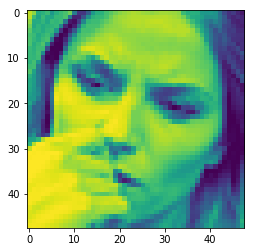

In [13]:
i = 2
plt.imshow(X_train[i].reshape(X_train[i].shape[0],X_train[i].shape[1]))

In [14]:
training_errors = []
testing_errors = []

In [15]:
model_NN = Keras_NN(X_train, y_train)

In [16]:
# trained_model = model_NN.train_model()

In [17]:
saved_model = model_NN.load_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/Users/visheshhemnani/anaconda3/envs/ml_proj/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [18]:
loss, acc = saved_model.evaluate(X_train, y_train, verbose=0)
print('Training loss: {}, acc: {}\n'.format(loss, acc))
training_errors.append(acc)

loss, acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Testing loss: {}, acc: {}\n'.format(loss, acc))
testing_errors.append(acc)

Training loss: 0.7082138153103112, acc: 0.7369117698324292

Testing loss: 1.480964902201945, acc: 0.5293953747894147



In [19]:
# get_webcam_feed(saved_model)

# Reducing data dimensions for SVM, PCA and NB

In [20]:
pca = PCA(100)
X_train_reduced = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_reduced = pca.transform(X_test.reshape(X_test.shape[0], -1))

In [21]:
model_SVM = SVM(X_train_reduced, np.argmax(y_train, axis=1))
# model_LR = LoisticRegression(X_train_reduced, np.argmax(y_train, axis=1))
model_LR = LoisticRegression(X_train.reshape(X_train.shape[0], -1), np.argmax(y_train, axis=1))
model_NB = NaiveBayes(X_train.reshape(X_train.shape[0], -1), np.argmax(y_train, axis=1))


In [22]:
saved_model = model_LR.load_model()

lr_acc = saved_model.score(X_train_reduced, np.argmax(y_train, axis=1))
training_errors.append(lr_acc)

lr_acc = saved_model.score(X_test_reduced, np.argmax(y_test, axis=1))
testing_errors.append(lr_acc)

/Users/visheshhemnani/anaconda3/envs/ml_proj/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/visheshhemnani/anaconda3/envs/ml_proj/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/visheshhemnani/anaconda3/envs/ml_proj/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [23]:
# model_LR.train_model()

In [24]:
# model_NB.dump_model(model_NB.train_model()) 

In [25]:
saved_model = model_NB.load_model()

lr_acc = saved_model.score(X_train.reshape(X_train.shape[0], -1), np.argmax(y_train, axis=1))
training_errors.append(lr_acc)

lr_acc = saved_model.score(X_test.reshape(X_test.shape[0], -1), np.argmax(y_test, axis=1))
testing_errors.append(lr_acc)

In [26]:
training_errors
testing_errors

[0.7369117698324292, 0.37535267686091467, 0.26395903723571007]

[0.5293953747894147, 0.3755920869322931, 0.24742268041237114]

In [27]:
saved_model = model_SVM.load_model()

/Users/visheshhemnani/anaconda3/envs/ml_proj/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
saved_model.predict(X_train.reshape(X_train.shape[0], -1))

In [ ]:
saved_model = model_SVM.load_model()

lr_acc = saved_model.score(X_train.reshape(X_train.shape[0], -1), np.argmax(y_train, axis=1))
training_errors.append(lr_acc)

# lr_acc = saved_model.score(X_test.reshape(X_test.shape[0], -1), np.argmax(y_test, axis=1))
# testing_errors.append(lr_acc)

/Users/visheshhemnani/anaconda3/envs/ml_proj/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [27]:
training_errors.append(0.9984325472848236)
testing_errors.append(0.31819448314293675)

In [28]:
model_names = ["NeuralNet","LogReg","NaiveBayes", "SVM"]
training_acc_df = pd.DataFrame(training_errors ,columns=['accuracy'])
training_acc_df['type'] = "Training"
training_acc_df['model'] = model_names
testing_acc_df = pd.DataFrame(testing_errors,columns=['accuracy'])
testing_acc_df['type'] = "Testing"
testing_acc_df['model'] = model_names
acc_df = pd.concat([training_acc_df, testing_acc_df])
acc_df['accuracy'] = acc_df['accuracy']*100

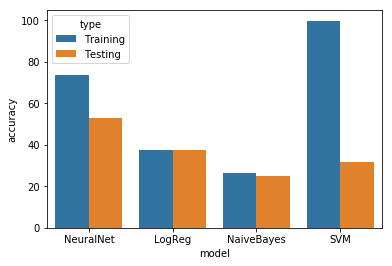

In [29]:
ax = sns.barplot(x = 'model',y = "accuracy",hue="type", data=acc_df)
